In [2]:
seed = 0

import os
import sys

os.chdir('..')
utils_path = os.path.abspath("./utilities/")
sys.path.append(utils_path)

from load_data import load_fullECAI
from evaluation import *
from evaluation import _my_scorer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, Normalizer
from sklearn.metrics import euclidean_distances
import joblib
from joblib import Parallel, delayed
import shap

from igraph import Graph
import igraph as ig

/home/azaelcarrillo/miniconda3/envs/XAI_credit/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import powerlaw

In [4]:
saving_paths = ['./results/figures/graphs/graph_distances',
                './results/figures/graphs/graph_degrees',
                './results/figures/graphs/graph_strengths']

for path in saving_paths:
    if not os.path.exists(path):
        os.makedirs(path)

In [5]:
### LOAD DATA ###
dataset = load_fullECAI()
# Prep data
X = dataset.drop('status', axis=1)
y = dataset.loc[:, 'status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=seed, stratify=y)

In [9]:
models_paths = ['./results/XGBoost/GridSearchCV_22-03-22_03-27-03/models/best/best_xgb.pkl', 
                './results/Basic1/models/RandomForestClassifier.pkl',
                './results/Basic1/models/LogisticRegression.pkl',
                './results/Basic1/models/LinearDiscriminantAnalysis.pkl']

In [15]:
pl_fit.supported_distributions

{'power_law': powerlaw.Power_Law,
 'lognormal': powerlaw.Lognormal,
 'exponential': powerlaw.Exponential,
 'truncated_power_law': powerlaw.Truncated_Power_Law,
 'stretched_exponential': powerlaw.Stretched_Exponential,
 'lognormal_positive': powerlaw.Lognormal_Positive}

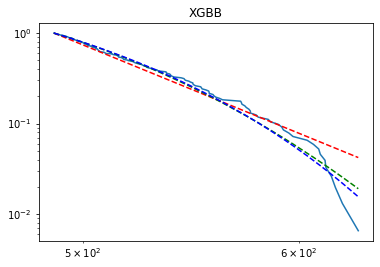

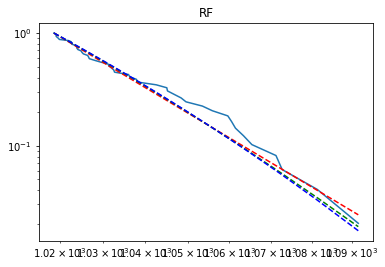

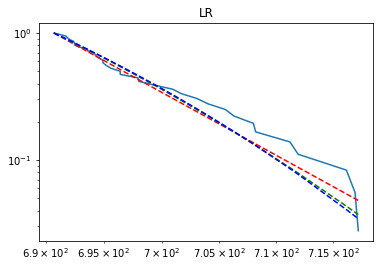

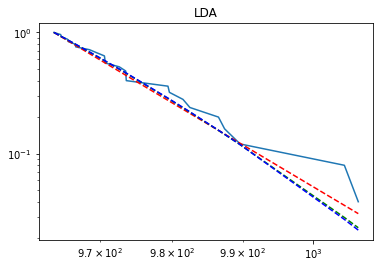

In [28]:
identifier = 'reduced_graphs_2'
optims = {'best_xgb': 'reduced_20000.pkl',
          'RandomForestClassifier': 'reduced_15000.pkl',
          'LogisticRegression': 'reduced_899.pkl',
          'LinearDiscriminantAnalysis': 'reduced_224.pkl'}

names = {'best_xgb': 'XGBB',
         'RandomForestClassifier': 'RF',
         'LogisticRegression': 'LR',
         'LinearDiscriminantAnalysis': 'LDA'}

for model in models_paths:
    model_folder = '/'.join(model.split('/')[:-1])
    model_name = model.split('/')[-1].split('.')[0]
    
    reduced_graphs_path = '{}/{}/{}'.format(model_folder, identifier, model_name)
    path = reduced_graphs_path + '/' + optims[model_name]
    results_graph = joblib.load(path)
    
    g = results_graph[3]
    #values = g.degree(g.vs)
    #values = g.strength(g.vs, weights=g.es['weight'])
    values = g.strength(g.vs, weights=1/(1+np.array(g.es['weight']))) 
    
    pl_fit = powerlaw.Fit(values, verbose=False)
    pl_fit.distribution_compare('power_law', 'exponential')
    pl_fit.distribution_compare('power_law', 'lognormal')
    pl_fit.distribution_compare('power_law', 'stretched_exponential')
    
    fig, ax = plt.subplots()
    pl_fit.plot_ccdf(ax=ax)
    pl_fit.power_law.plot_ccdf(ax=ax, color='r', linestyle='--')
    pl_fit.lognormal.plot_ccdf(ax=ax, color='g', linestyle='--')
    pl_fit.stretched_exponential.plot_ccdf(ax=ax, color='b', linestyle='--')
    
    plt.title(names[model_name])
    
    plt.savefig('results/figures/graphs/powerlaw/{}_pwr.png'.format(names[model_name]), bbox_inches='tight', dpi=300, transparent=True)

In [58]:


for i, model in enumerate(models_paths):
    cutoff = optims[i]
    model_folder = '/'.join(model.split('/')[:-1])
    model_name = model.split('/')[-1].split('.')[0]
    results = joblib.load('{}/{}_reduced_graphs_efficiency.pkl'.format(model_folder, model_name))
    result = results[cutoff] # Only 4 smallest graphs
    model_results = joblib.load(model)
    
    
    try:
        g =result[3]
        values = g.degree(g.vs)
        
        pl_fit = powerlaw.Fit(values, verbose=False)
        #pl_fit.distribution_compare('power_law', 'exponential')
        #pl_fit.distribution_compare('power_law', 'lognormal')

        pl_fit.plot_ccdf(ax=ax)
        
        #path = saving_paths[1] + '/{}_co{}_deghist.svg'.format(model_name, i+1)
        #plt.savefig(path, bbox_inches='tight', transparent=True)

    except:
        print('Cannot get hisogram from model: {}, cutoff: {}'.format(model_name, i))

KeyboardInterrupt: 

In [55]:
i = 0 
model = models_paths[i]
cutoff = optims[i]
model_folder = '/'.join(model.split('/')[:-1])
model_name = model.split('/')[-1].split('.')[0]
results = joblib.load('{}/{}_reduced_graphs_efficiency.pkl'.format(model_folder, model_name))
result = results[cutoff] # Only 4 smallest graphs
model_results = joblib.load(model)

g = result[3]
values = g.degree(g.vs)
pl_fit_op = powerlaw.Fit(values, verbose=False)

pl_fit_op.distribution_compare('power_law', 'exponential')
pl_fit_op.distribution_compare('power_law', 'lognormal')

(-9.17646013572905, 0.007121924679305257)

overflow encountered in double_scalars
invalid value encountered in multiply


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
invalid value encountered in double_scalars
invalid value encountered in double_scalars
Not enough data. Returning nan
Not enough data. Returning nan
Mean of empty slice.
invalid value encountered in double_scalars
No valid fits found.
Not enough data. Returning nan
Degrees of freedom <= 0 for slice
invalid value encountered in true_divide
invalid value encountered in double_scalars
No valid fits found.
Not enough data. Returning nan


<AxesSubplot:>

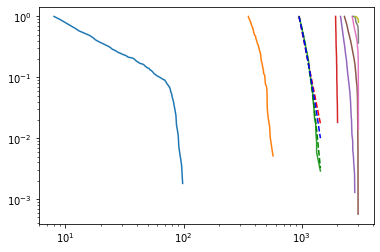

In [56]:
fig, ax = plt.subplots()
for result in results:
    g = result[3]
    values = g.degree(g.vs)
    
    pl_fit = powerlaw.Fit(values, verbose=False)
    pl_fit.distribution_compare('power_law', 'exponential')
    pl_fit.distribution_compare('power_law', 'lognormal')
    
    pl_fit.plot_ccdf(ax=ax)

pl_fit_op.power_law.plot_ccdf(ax=ax, color='r', linestyle='--')
pl_fit_op.lognormal.plot_ccdf(ax=ax, color='g', linestyle='--')
pl_fit_op.exponential.plot_ccdf(ax=ax, color='b', linestyle='--')

<AxesSubplot:>

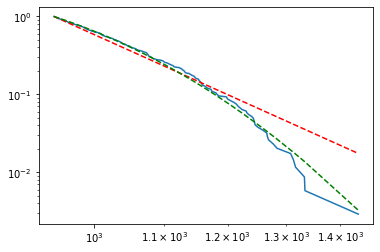

In [52]:
fig, ax = plt.subplots()
for result in results:
    g = result[3]
    values = g.degree(g.vs)
    
    pl_fit = powerlaw.Fit(values, verbose=False)
    pl_fit.distribution_compare('power_law', 'exponential')
    pl_fit.distribution_compare('power_law', 'lognormal')
    
    pl_fit.plot_ccdf(ax=ax)

pl_fit.power_law.plot_ccdf(ax=ax, color='r', linestyle='--')
pl_fit.lognormal.plot_ccdf(ax=ax, color='g', linestyle='--')
pl_fit.exponential.plot_ccdf